## Case Study
In this demo, we will leverage satellite data to identify water extent, get lake boundary and more.

## 1. Derive improved water extent layer by aligning and joining multiple layers.

### Background:
INTR (interpretation layer) provides the interpretation of water based the recoded results of the five diagnostic tests to identify specific surface water conditions:
    - 0: Not water
    - 1: Water – high confidence
    - 2: Water – moderate confidence
    - 3: Potential wetland
    - 4: Water or wetland – low confidence
MASK (mask layer) indicates where cloud, cloud shadow, snow are true, or where the percent slope or hillshade thresholds were exceeded.
    - 32 (i.e. 2^5) unique values indicating the combination of the existance of the five (cloud, cloud shadow, snow, above-threshold-slope, above-threshold-hillshade).

The INTR layer alone is not accurate enough for water interpretation, for example:
1. When there are cloud, cloud shadow or snow exists, the water interpretation might not be accurate as the water might be covered by the cloud, cloud shadow or snow.
2. When the area's slope or hillshade is above certain threshold, the area is too steep or shaded to retain water, in which case water is certainly not existed no matter what INTR layer value is.

Therefore, by combining these two layers, we are able to draw a better interpretation about water. In fact, this is how INWM (interpreted layer with mask applied) Layer in Landsat is computed, and we are leveraging our query to achieve the same derived layer to showcase how to join multiple layers.

### Implementation
We join the values from both layers for each area, and generate our improved water interpretation value based on the following rule:
1. When mask value is 0 (meaning that all five conditioins are not existed, i.e. the area is clear from any cloud, cloud_shadow, snow, or above-the-threshold slop or hillshade), value from INTR value will be used as the INTR value is accurate enough for clear areas.
2. When mask value is greater than 7 (meaning that the area's slope or hillshade is above the threshold so the area cannot retain any water), value will be set to 0.
3. When mask value is between 0 and 7 (meaning there are cloud or cloud shadow or snow exists), value will be set to 9 to indicate that the area's condition is too cloudy/snowy to decide the water existance.

More [details](https://prd-wret.s3-us-west-2.amazonaws.com/assets/palladium/production/s3fs-public/atoms/files/LSDS-1331-LandsatDynamicSurfaceWaterExtent-DSWE-ProductGuide-v3.0_%202019_03_19.pdf) on these layers.

### Key Takeaways
This part shows how to align/join multiple satellite layers and aggregate them into a derived layer, which is a very common use case for using satellite data to derive further information (e.g. compute NDVI layer from visible and near-infrared layers for vegetation management)

In [1]:
import requests
import tarfile
import io

# download sample data from DAX
dax_url = 'https://dax-cdn.cdn.appdomain.cloud/mono-lake-surface-water-extent-landsat8-data/1.0.0/mono-lake-surface-water-extent-landsat8-data.tar.gz'
tarfile.open(fileobj=io.BytesIO(requests.get(dax_url).content)).extractall()

Waiting for a Spark session to start...
Spark Initialization Done! ApplicationId = app-20200512211356-0002
KERNEL_ID = e97695b3-7e65-47bf-bb0d-4b134861cafc


In [2]:
intr = spark.read.parquet('mono_lake/layer=INTR/date=20191231')
intr.createOrReplaceTempView('intr')
mask = spark.read.parquet('mono_lake/layer=MASK/date=20191231')
mask.createOrReplaceTempView('mask')

In [3]:
query_str = """
SELECT intr.lat, intr.lon, 
CASE
    WHEN mask.value == 0 THEN intr.value
    WHEN mask.value > 7 THEN 0
    ELSE 9
END AS value
FROM intr, mask
WHERE intr.lat = mask.lat AND intr.lon = mask.lon
"""

df = spark.sql(query_str).toPandas()

Let's convert dataframe back to raster data for visualization

In [4]:
! pip install -q pyrip
! conda install -q gdal=2.3.3

%matplotlib inline

from pyrip.plot import plot
from pyrip.transform import df_to_tif
# ! find . -name libgdal.so*
os.environ['LD_LIBRARY_PATH'] = os.environ['LD_LIBRARY_PATH'] + ':/home/spark/shared/conda/envs/python3.6/lib/'

Visualize INTR layer

In [5]:
bbox = min(df['lon']), min(df['lat']), max(df['lon']), max(df['lat'])

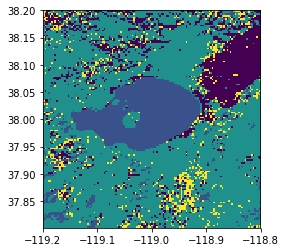

In [6]:
intr_tif = df_to_tif(intr.toPandas(), 'intr.tif', xres=0.003, bbox = bbox, nodata=255, dtype='UInt16')
plot(intr_tif)

Visualize MASK layer

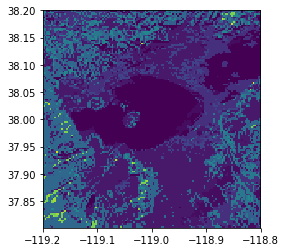

In [7]:
mask_tif = df_to_tif(mask.toPandas(), 'mask.tif', xres=0.003, bbox = bbox, nodata=255, dtype='UInt16')
plot(mask_tif)

Visualize merged layer

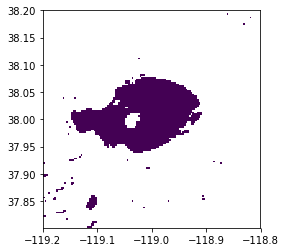

In [8]:
merged_tif = df_to_tif(df[df['value']==1], 'merged.tif', xres=0.003, bbox = bbox, nodata=255, dtype='UInt16')
plot(merged_tif)

### (Optional) Advanced Topic: How to aligen layers when they are not naturally spatially aligned.

Above query assumes all the input layers are naturally spatially aligned - they are using the same grid system and have the same resolution so we can join them based on latitude and longitude directly. However, for many of the cases we are facing layers that are either collected from different products, or collected from the same product but with different resolutions. So how can we align them when they are not naturally aligned?

It turns out we can align arbitrary layers by underlying using [geohash](https://www.ibm.com/support/knowledgecenter/SSHRBY/com.ibm.swg.im.dashdb.analytics.doc/doc/geo_geohashes.html) to do spatial alignment and we can use geohash's bit depth to control the resampling spatial resolution we need.

Now, let's assume the two layers we are using are not spatially aligned, and we want to align and join both layers with a resampling resolution around 100 meters. For simplicity, let's assume the new logic is: During resampling, if any pixel in the newly resampled region indicate it is a clear day, then use the intrepretion layer value, otherwise mark as -1.

In [9]:
spark._jvm.org.apache.spark.sql.types.SqlGeometry.registerAll(spark._jsparkSession)

bit_depth = 35
query_str = """
SELECT
ST_Y(ST_BoundingBoxCenter(ST_Envelope(ST_GeohashDecode(intr.geohash)))) AS lat,
ST_X(ST_BoundingBoxCenter(ST_Envelope(ST_GeohashDecode(intr.geohash)))) AS lon,
CASE
    WHEN mask.is_clear THEN intr.value
    ELSE -1
END AS value
FROM
    (SELECT ST_GeohashEncode(ST_Point(lon, lat), {0})[0] as geohash, avg(value) as value
    FROM intr
    GROUP BY ST_GeohashEncode(ST_Point(lon, lat), {0})[0]) intr,
    
    (SELECT ST_GeohashEncode(ST_Point(lon, lat), {0})[0] as geohash, array_contains(collect_list(value), 0) as is_clear
    FROM mask
    GROUP BY ST_GeohashEncode(ST_Point(lon, lat), {0})[0]) mask
    
WHERE mask.geohash = intr.geohash
""".format(bit_depth)
df2 = spark.sql(query_str).toPandas()

Again, let's convert dataframe back to raster data for visualization

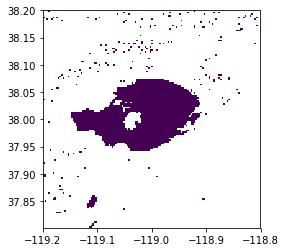

In [10]:
merged_tif_2 = df_to_tif(df2[df2['value']==1], 'merged_2.tif', xres=0.003, bbox = bbox, nodata=255, dtype='UInt16')
plot(merged_tif_2)

## 2. Apply Machine Learning to Further Improve the Accuracy

From the previous section, we have improved the water extent accuracy by aligning and merging two layers. But we can actually further improve it by applying machine learning on top of the result. As we could see from the above visualization, there are many sparse and isolated pixels marked as water. However, those are not likely to be actual water as water usually covers at least a decent amount of area. Therefore, a proper clustering can help us identify real water area (clusters) while remove noises (isolated points that are falsely marked as water)


### Implementation
1. get all the points that are marked as water (i.e. value=1) from previous step
2. apply DBSCAN clustering to the water points and generate clusters. DBSCAN is the preferred algo in this case as water areas are non-flat geometry with uneven cluster sizes.
3. remove noises (water with area less than a certain threshold). This is done in two places:
    1. Remove non-cluster points. During DBSCAN clustering, we use eps (the maximum distance between two points to be considered as in the same neighborhood) and min_samples (number of samples in a neighborhood for a point to be considered as a core point) to identify non-cluster points. Points that cannot form a neighborhood with min_samples are clustered as -1, which means they cannot form a cluster.
    2. Remove small-cluster points. In this case, we are only interested in water areas that cover at least a decent amount of area (mono lake specifically), so we filter out all clusters with cluster size smaller than our given min_cluster_size.

In [11]:
import numpy as np
from sklearn.cluster import DBSCAN

In [12]:
# 1. get water coordinates
water_df = df[df['value']==1]

In [13]:
# 2. cluster the points using DBSCAN
clusters = DBSCAN(eps=0.06/6371., min_samples=10, algorithm='ball_tree', metric='haversine').fit(np.radians(water_df[['lat', 'lon']].values))
water_df['cluster'] = clusters.labels_

/opt/ibm/conda/miniconda3.6/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


In [14]:
# 3. remove non-cluster points (cluster label = -1) and small clusters (with cluster size smaller than min_cluster_size threshold)
# in this case, we use 5000 because we are only interested in the Mono Lake area and want to filter out other water areas like small river segments.
cluster_size = water_df.groupby('cluster').size()
min_cluster_size = 5000
target_clusters = cluster_size[cluster_size >= min_cluster_size].index.tolist()
try:
    target_clusters.remove(-1)
except ValueError:
    pass
print('qualified cluster(s): ', target_clusters)
result_df = water_df[water_df['cluster'].isin(target_clusters)]

qualified cluster(s):  [0]


Let's visualize the ML-processed layer

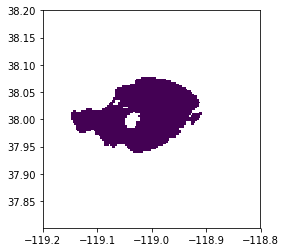

In [15]:
result_tif = df_to_tif(result_df, 'processed.tif', xres=0.003, bbox=bbox, nodata=255, dtype='UInt16')
plot(result_tif)

As we could see above, we get back a clean water region (Mono Lake area)

## 3. Leverage Spatiotemporal Library to Do MORE!

So far, we have successfully computed an improved and cleaned version of the water area. However, at this stage, everything is still either scatter points (each row in pandas dataframe is a single water point) or raster images (the tif images we generated for visualization). We might be also interested in getting the real boundary (i.e. a polygon) of the area which can be used for future study (e.g. study area change over the time, location-based water resouce planning, etc.).  So how can we do this?  Fortunately, Watson Studio comes with a handy Spatiotemporal library which can be used to achieve this.


### Implementation
1. get all coordinates from the previous result which represent water locations.
2. compute a convex hull over these points as the convex hull boundary of the lake. Note that there are various of definitions about the "boundary" of a set of points (convex hull, concave hull, generalized alpha-shape, etc.) and in this case we use convex hull as an example/

In [16]:
from pyst import STContext
stc = STContext(spark.sparkContext._gateway)

In [17]:
points = []
for row in result_df.itertuples():
    points.append(stc.point(row.lat, row.lon))
hull = stc.convex_hull.compute_convex_hull(points)

now, we have the hull object, which is a spatial object that we can leverage to do various of spatial operations. Some simple examples:

In [18]:
# area in squared meters of the lake's convex hull
hull.area()

210543217.26007774

In [19]:
# the centroid
hull.centroid()

Point(38.00831995200045, -119.01380586533288)

In [20]:
# check if the given point is within the boundary
hull.contains(stc.point(38., -119.))

True

Finally, let's plot it on basemap!

Note that, since we are computing a [convex hull](https://en.wikipedia.org/wiki/Convex_hull), it is a "convex" boundary of the actual shape.

In [21]:
stc.generate_map(hull)

**In fact, you can do much more with spatiotemporal library and here are only some basic examples. [More info](https://cloud.ibm.com/docs/services/AnalyticsEngine?topic=AnalyticsEngine-geospatial-geotemporal-lib) can be found, especially the last "learn more" section where you can find notebook demos specificially for spatial support**